<a href="https://colab.research.google.com/github/HWANG-HOE-SUN/bigcon/blob/master/%EB%AA%A8%EB%8D%B8%EB%A7%81%ED%86%B5%ED%95%A9(2020_09_24).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,174 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 144676 files and d

In [3]:
#한글폰트 지정
plt.rc('font', family='NanumBarunGothic') 

# 데이터 생성

In [4]:
train = pd.read_excel('/content/drive/My Drive/빅콘폴더/최종 데이터셋 후보/train.xlsx')
train = train[train['판매단가'] < train['취급액']]

In [5]:
train['노출(분)'] = train['노출(분)'].replace(0, math.nan)
train['노출(분)'] = train['노출(분)'].fillna(method='ffill')

In [6]:
train.index = np.arange(7513)

In [7]:
test = pd.read_excel('/content/drive/My Drive/빅콘폴더/test.xlsx', header=1)

# Feature Engineering & 인코딩

- 판매단가, 주문량 log 변환


In [8]:
train['new판매단가'] = np.log(train['판매단가'])
train.drop('판매단가', inplace=True, axis=1)


train['new주문량'] = np.log(train['주문량'])
train.drop('주문량', inplace=True, axis=1)

In [9]:
train.head(3)

,Unnamed: 0,방송일시,노출(분),마더코드,상품코드,상품명,상품군,취급액,날짜,시간,요일,시,holiday,월,holiday(includeSS),실제_서울_최고기온,실제_서울_최저기온,실제_서울_강수량(mm),실제_서울_평균풍속(m/s),실제_서울_날씨,실제_수원_최고기온,실제_수원_최저기온,실제_수원_강수량(mm),실제_수원_평균풍속(m/s),실제_수원_날씨,실제_파주_최고기온,실제_파주_최저기온,실제_파주_강수량(mm),실제_파주_평균풍속(m/s),실제_파주_날씨,예보_서울_강수확률,예보_서울_강수량,예보_서울_하늘상태,예보_서울_일최고기온,예보_서울_일최저기온,예보_일산_강수확률,예보_일산_강수량,예보_일산_일최고기온,예보_일산_일최저기온,예보_수원_강수확률,예보_수원_강수량,예보_수원_일최고기온,예보_수원_일최저기온,계절,DATE,미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),초미세먼지(㎍/㎥),분류,MONTH,HOUR,DAY,Active Users,new판매단가,new주문량
0,17373,2019-06-15 00:00:00,20.0,100305,200981,오모떼 미라클쉐이핑 브라팬티 시즌3,inner,16517000,2019-06-15,00:00:00,5,0,0,6,1,27.4,17.9,2.1,2.5,구름조금/비/천둥번개,26.8,17.1,0.3,2.4,구름조금/소나기/안개,27.6,15.3,0.0,1.7,구름조금/비,10.337838,0.210526,1.925676,26.368421,17.0,8.986486,0.078947,25.105263,16.0,8.513514,0.078947,26.263158,16.0,2,20190615,36.0,21.36,0.04308,0.01296,0.364,0.003,f1,6,0,sat,118574.0,11.686879,4.933022
1,17374,2019-06-15 00:20:00,20.0,100305,200981,오모떼 미라클쉐이핑 브라팬티 시즌3,inner,44829000,2019-06-15,00:20:00,5,0,0,6,1,27.4,17.9,2.1,2.5,구름조금/비/천둥번개,26.8,17.1,0.3,2.4,구름조금/소나기/안개,27.6,15.3,0.0,1.7,구름조금/비,10.337838,0.210526,1.925676,26.368421,17.0,8.986486,0.078947,25.105263,16.0,8.513514,0.078947,26.263158,16.0,2,20190615,36.0,21.36,0.04308,0.01296,0.364,0.003,f1,6,0,sat,118574.0,11.686879,5.931487
2,17375,2019-06-15 00:40:00,20.0,100305,200981,오모떼 미라클쉐이핑 브라팬티 시즌3,inner,56057000,2019-06-15,00:40:00,5,0,0,6,1,27.4,17.9,2.1,2.5,구름조금/비/천둥번개,26.8,17.1,0.3,2.4,구름조금/소나기/안개,27.6,15.3,0.0,1.7,구름조금/비,10.337838,0.210526,1.925676,26.368421,17.0,8.986486,0.078947,25.105263,16.0,8.513514,0.078947,26.263158,16.0,2,20190615,36.0,21.36,0.04308,0.01296,0.364,0.003,f1,6,0,sat,118574.0,11.686879,6.155001


In [10]:
train['holiday(includeSS)'][20]

1

- 시간대(잘팔리는)

In [11]:
time = train.groupby('HOUR').aggregate(np.mean)

time_rank = {}
rank = 1 
for idx, row in time.sort_values(by='new주문량').iterrows():
    time_rank[idx] = rank
    rank += 1

In [12]:

prime_time = []

for idx, row in train.iterrows():
    prime_time.append(time_rank[row.HOUR])
    
train['prime_time'] = prime_time

- 요일(잘팔리는)

In [13]:
day = train.groupby('요일').aggregate(np.mean)

day_rank = {}
rank = 1 
for idx, row in day.sort_values(by='new주문량').iterrows():
    day_rank[idx] = rank
    rank += 1
    
prime_day = []

for idx, row in train.iterrows():
    prime_day.append(day_rank[row.요일])
    
train['prime_day'] = prime_day

# 마더코드 관련 처리
- test랑 겹치는 마더코드(아래 노출시간 대비 topcode는 주석처리 했음)

In [14]:
'''
#노출시간 대비 주문량 많은 topcode
def hand_by_momcode(data):
  momcodegroup = data.groupby(['마더코드']).sum()
  momcodegroup['주문량/노출'] = momcodegroup['주문량']/momcodegroup['노출(분)']
  topcode = list(momcodegroup.sort_values('주문량/노출', ascending=False).index[:50]) #탑50개
  return topcode

hand_by_momcode(train) # train으로 topcode생성
이것보다 test와 겹치는 마더코드가 많은것을 topcode로 하는게 더 성능이 좋다고 한다.
'''

"\n#노출시간 대비 주문량 많은 topcode\ndef hand_by_momcode(data):\n  momcodegroup = data.groupby(['마더코드']).sum()\n  momcodegroup['주문량/노출'] = momcodegroup['주문량']/momcodegroup['노출(분)']\n  topcode = list(momcodegroup.sort_values('주문량/노출', ascending=False).index[:50]) #탑50개\n  return topcode\n\nhand_by_momcode(train) # train으로 topcode생성\n이것보다 test와 겹치는 마더코드가 많은것을 topcode로 하는게 더 성능이 좋다고 한다.\n"

In [15]:
intercode = set(test['마더코드'].unique()).intersection(set(train['마더코드'].unique()))
interitem = train[train['마더코드'].isin(intercode)]

In [16]:
code = interitem.groupby('마더코드').aggregate(np.mean)

code_rank = {}
rank = 1
for idx, row in code.sort_values(by='new주문량').iterrows():
    code_rank[idx] = rank
    rank += 1

top_code = []

for idx, row in train.iterrows():
    if row.마더코드 in code_rank.keys():
        top_code.append(code_rank[row.마더코드])
    else:
        top_code.append(0)
        
train['top_code'] = top_code

- 분류 기준 topcode

In [17]:
cat = train.groupby('분류').aggregate(np.mean)

cat_rank = {}
rank = 1
for idx, row in cat.sort_values(by='new주문량').iterrows():
    cat_rank[idx] = rank
    rank += 1

top_cat = []

for idx, row in train.iterrows():
    top_cat.append(cat_rank[row.분류])
    
train['top_cat'] = top_cat

- 분류 변수 원핫/pca

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [19]:
enc1 = OneHotEncoder()
category = np.array(train['분류'])
category = category.reshape(-1, 1)

enc1.fit(category)
category_ = enc1.transform(category).toarray()

pca = PCA(n_components=2)
res = pca.fit_transform(category_)
res = pd.DataFrame(res, columns=['x1_cat','x2_cat'])

train['x1_cat'] = res['x1_cat']
train['x2_cat'] = res['x2_cat']

- 분류 변수 빈도수 인코딩

In [20]:
# 빈도수인코딩(위의 원핫+pca와 비교해보기)
def add_frequency_encoding(data,column): #데이터프레임,열을 받아서 빈도수인코딩열을 추가해줌
  enc_nom = (data.groupby(column).size())/len(data)
  data['freq_encode_{}'.format(column)] = data[column].apply(lambda x:enc_nom[x])
  print("freq_encode column was added")
  
add_frequency_encoding(train,'분류')

freq_encode column was added


- 실제 날씨(서울) # 잘팔리는 실제 서울 날씨

In [21]:
real = train.groupby('실제_서울_날씨').aggregate(np.mean) # real = 서울의 여러 기상정보(흐림,비,소나기,안개 등의 범주형정보) 31개에 따라 그룹핑한것.

real_rank = {}
rank = 1
for idx, row in real.sort_values(by='new주문량').iterrows(): # 주문량이 좋은 날씨조건일수록 ex)구름많음,비,소나기등... rank수치가 큼.
    real_rank[idx] = rank
    rank += 1

top_real_weather = [] # 7513개의 데이터별로 해당하는 날씨정보의 주문량 랭크가 들어있음.(서열)

for idx, row in train.iterrows():
    top_real_weather.append(real_rank[row.실제_서울_날씨])
    
train['top_real_weather'] = top_real_weather

- 실제 날씨 통합

In [22]:
real_total_weather = pd.read_excel('/content/drive/My Drive/빅콘폴더/날씨_실제/날씨통합.xlsx')

train['실제_최고기온'] = real_total_weather['최고기온']
train['실제_최저기온'] = real_total_weather['최저기온']
train['실제_강수량'] = real_total_weather['강수량']
train['실제_평균풍속'] = real_total_weather['평균풍속']

# 카테고리별, 시간대별 상품군 주문량 EDA

In [23]:
# 상품군내 마더코드별 주문량
multi_grouped = train.groupby(['상품군','마더코드'])
MultiGroup = multi_grouped['new주문량'].sum()
MultiGroup = MultiGroup.reset_index()

In [24]:
item = list(set(MultiGroup['상품군']))

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45908 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_

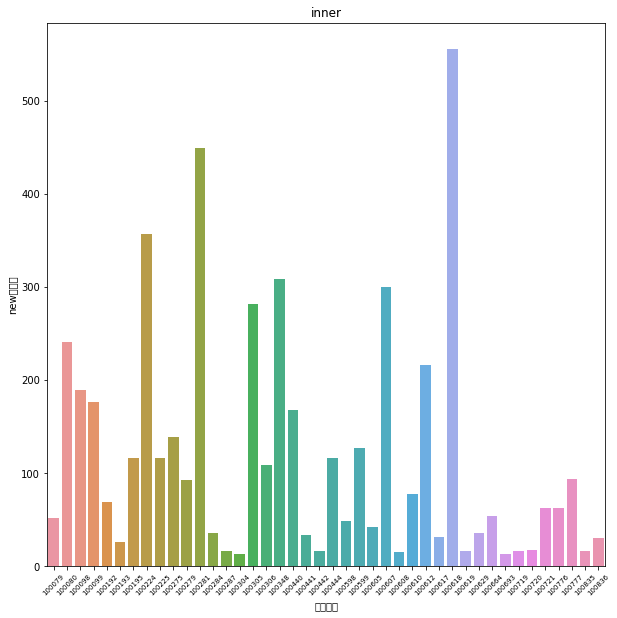

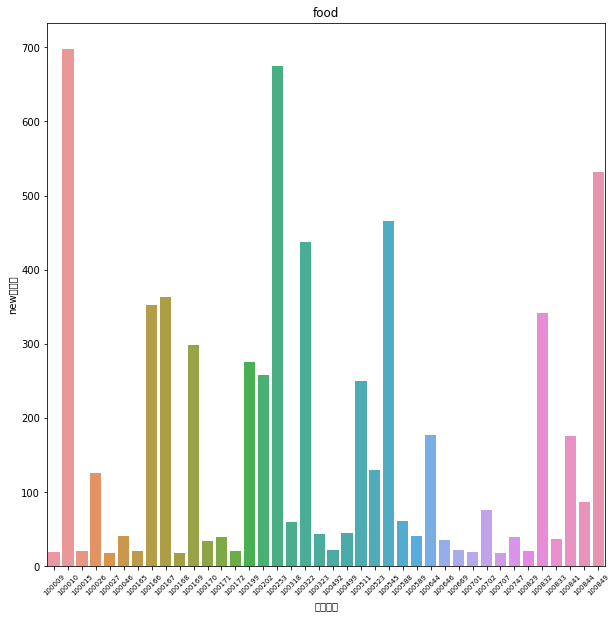

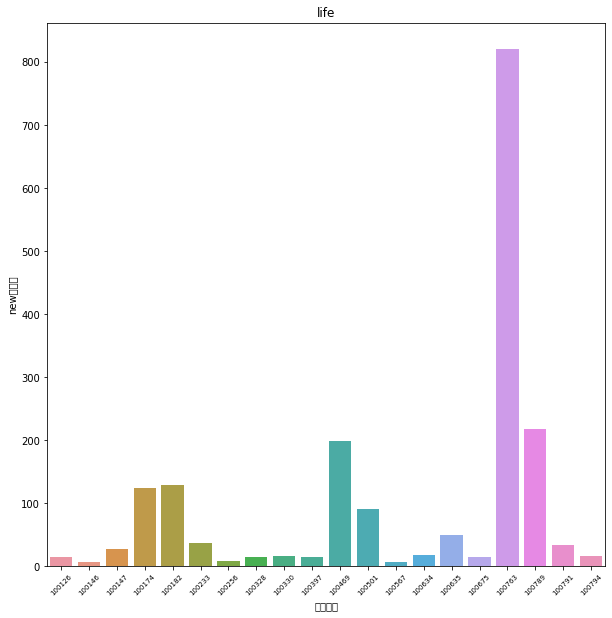

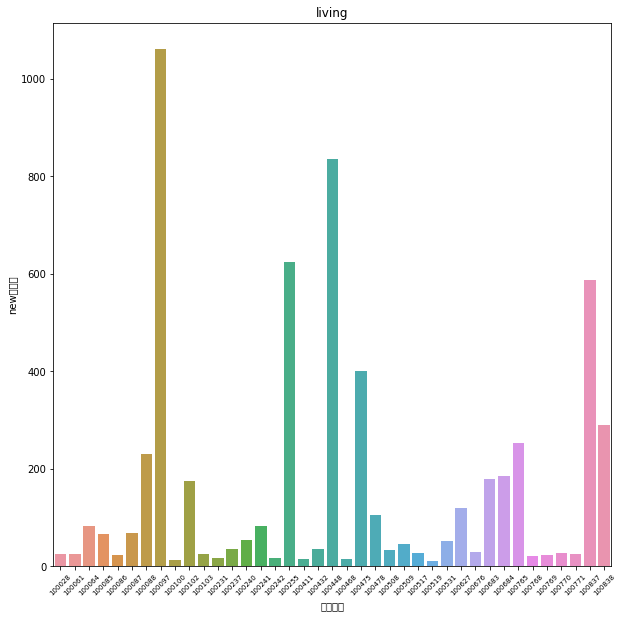

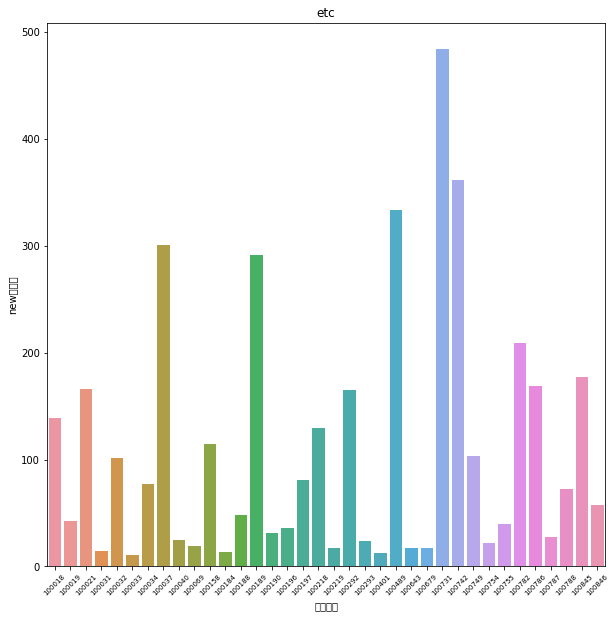

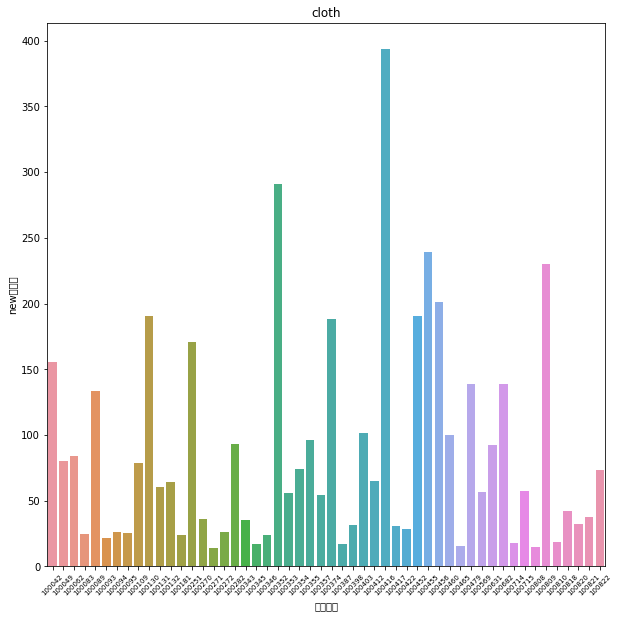

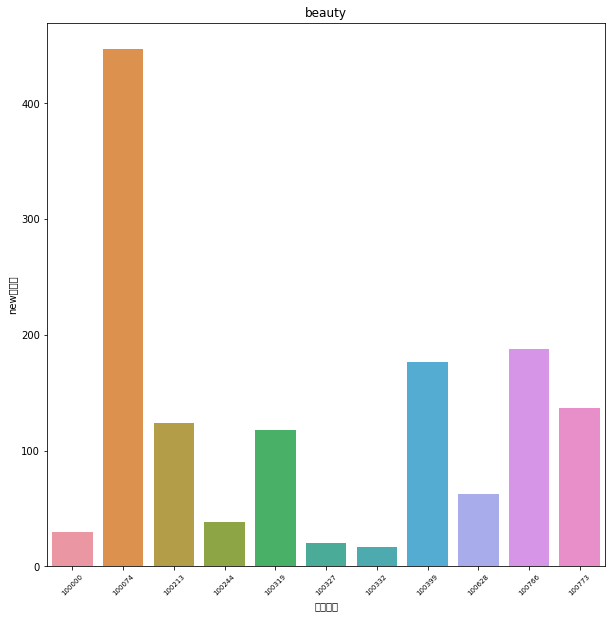

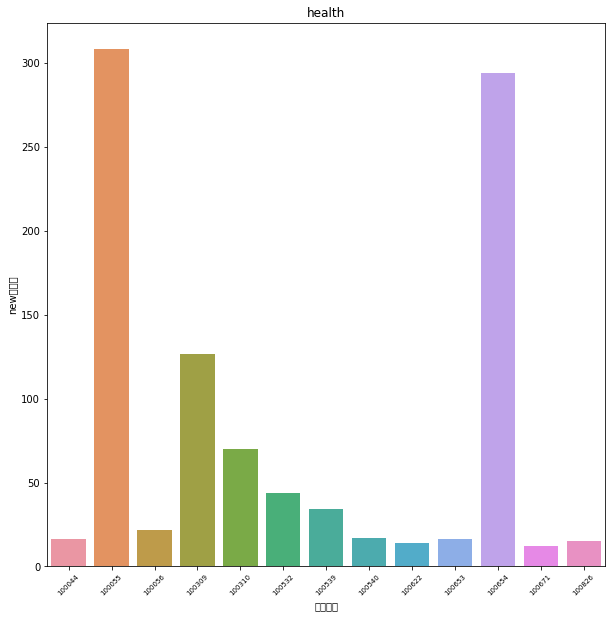

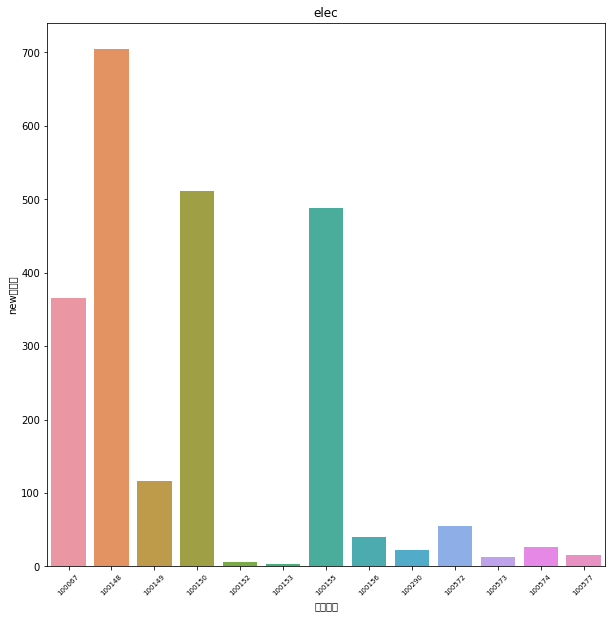

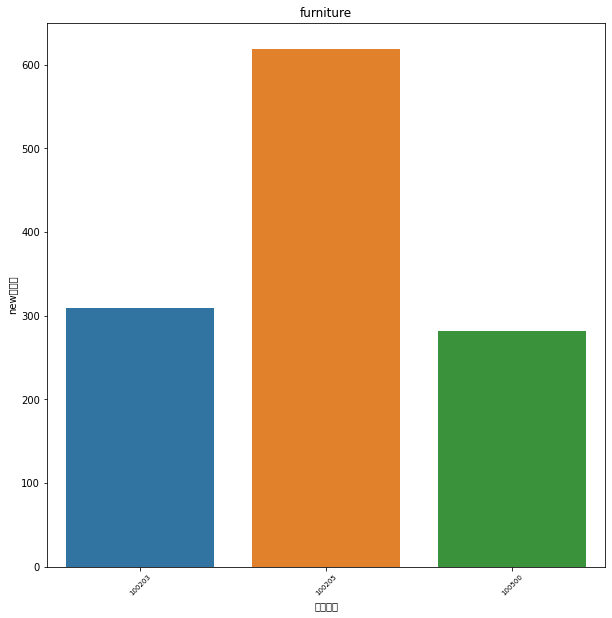

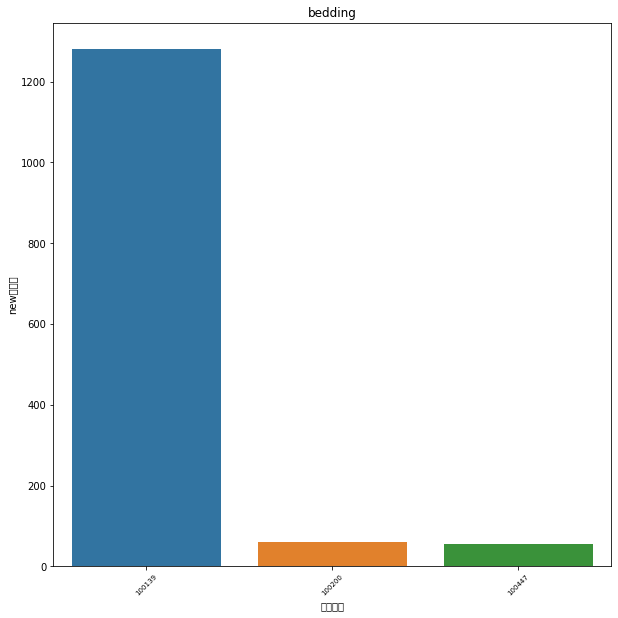

In [25]:
for i in item:
    plt.figure(figsize=(10,10))
    sns.barplot(data=MultiGroup[MultiGroup['상품군']==i], x='마더코드', y='new주문량')
    plt.title(i)
    plt.xticks(rotation=45, size=7)

- 시간대 상품군별 주문량

In [26]:
hour_grouped = train.groupby(['시','상품군'])
HourGroup = hour_grouped['new주문량'].sum()
HourGroup = HourGroup.reset_index()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_te

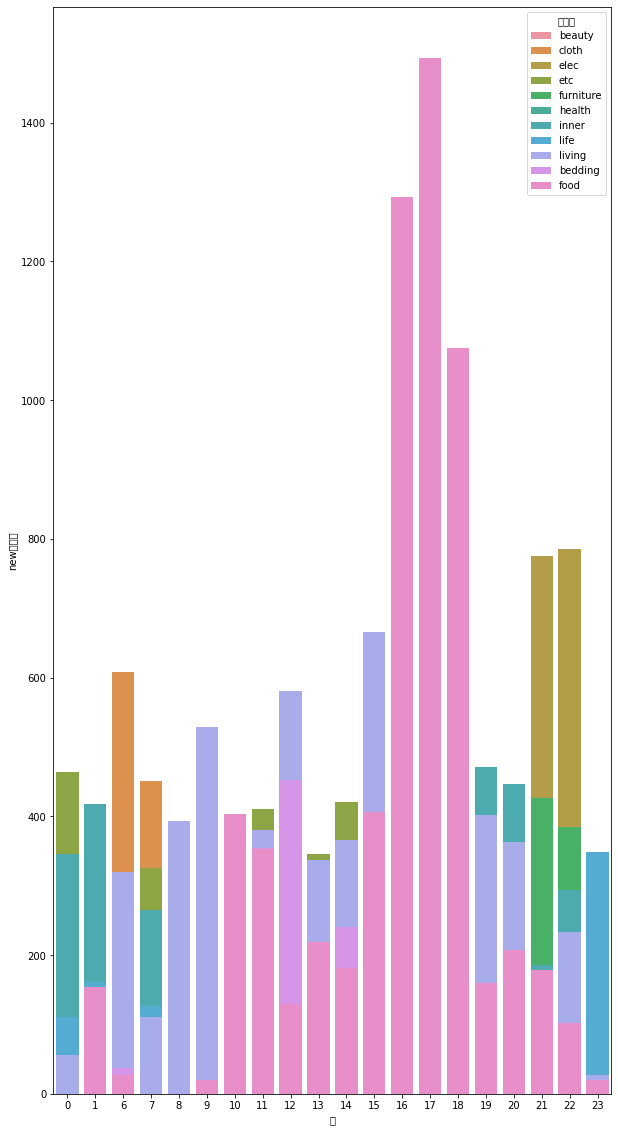

In [27]:
#  좀 더 카테고리별 구분이 잘되게 보면 좋을듯 + 더 다양하게 시각화해서 의미 뽑아보자(To 편성표 최적화)
plt.figure(figsize=(10,20)) 
sns.barplot(data=HourGroup, x='시', y='new주문량', hue='상품군', dodge=False)

In [28]:
np.corrcoef(train['new주문량'],train['new판매단가']) # 가격과 주문량은 강한 음의 상관관계

array([[ 1.        , -0.86135885],
       [-0.86135885,  1.        ]])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

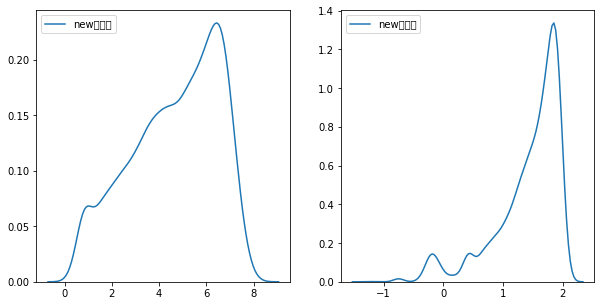

In [29]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.kdeplot(train['new주문량'], ax=ax[0]) #커널 밀도추정
sns.kdeplot(np.log(train['new주문량']), ax=ax[1])

In [30]:
#corr_mat = train.corr()
#corr_mat['new주문량'].sort_values(ascending=False)

In [31]:
# train.drop(['Unnamed: 0', '방송일시', '상품명', '상품군', 'holiday', '요일', 'HOUR', '마더코드'], inplace=True, axis=1)
# 방송일시, 상품명, 상품군, holiday(주말), 요일, HOUR, 마더코드

# 모델학습 데이터 생성 및 분리

# 모델 생성 및 학습

- 모든 카테고리별로 자동 변수생성

In [32]:
category_list = train['상품군'].unique().tolist()
for i in category_list:
  globals()['x_{}'.format(i)] = train.loc[train['상품군']==i] #카테고리에 해당하는 주문량제외 train데이터 할당
  globals()['y_{}'.format(i)] = train['new주문량'].loc[train['상품군']==i] #카테고리에 해당하는 train의 주문량을 할당

# Split

- 4번. 카테고리별 2:1 비율로 통째로 split, 피팅

In [33]:
# x_category, y_category를 train test 스플릿해줌.
from sklearn.model_selection import train_test_split
for i in category_list:
  x_for_split = globals()['x_{}'.format(i)]
  y_for_split = globals()['y_{}'.format(i)]
  globals()['x_train_{}'.format(i)], globals()['x_test_{}'.format(i)], globals()['y_train_{}'.format(i)], globals()['y_test_{}'.format(i)] = train_test_split(x_for_split, y_for_split, test_size=0.33, random_state=1234)
# 카테고리별로 X_train_카테고리 , X_test_카테고리, Y_train_카테고리, Y_test_카테고리 생성됐음.

In [34]:
x_train_beauty, x_test_beauty # 2:1비율로 나뉘어짐.

(      Unnamed: 0                방송일시  노출(분)  ...    실제_최저기온     실제_강수량   실제_평균풍속
 3451       21025 2019-07-20 07:00:00   20.0  ...  25.033333   0.600000  3.033333
 866        18302 2019-06-24 10:30:00   30.0  ...  18.900000   0.000000  1.700000
 3603       21189 2019-07-21 16:20:00   20.0  ...  23.666667   7.900000  2.000000
 6571       24425 2019-08-21 01:40:00   10.0  ...  23.266667   0.533333  1.166667
 4443       22087 2019-07-30 07:50:00   10.0  ...  25.500000  12.366667  3.233333
 ...          ...                 ...    ...  ...        ...        ...       ...
 7276       25161 2019-08-29 01:00:00   20.0  ...  19.300000  22.533333  2.066667
 1907       19370 2019-07-05 08:30:00   30.0  ...  19.233333   0.000000  1.333333
 1341       18779 2019-06-29 19:40:00   20.0  ...  19.533333   2.066667  1.100000
 7406       25291 2019-08-30 19:20:00   20.0  ...  17.900000   0.066667  2.033333
 1611       19066 2019-07-02 12:20:00   20.0  ...  19.666667   0.000000  1.900000
 
 [144 rows x 7

- 6번. 카테고리별 20분단위로 3갈해서 각각 피팅

In [74]:
#그룹내 방송행간의 시간차이(날짜-날짜) <= 해당그룹 최대 노출(분)인가? 
# 검토해서 분리하는 함수

def split_shoprow(df, time): 
    shoprow1 = pd.DataFrame()  # train
    shoprow2 = pd.DataFrame()  # validation 
    size = len(df)

    if (len(df)==1):
      shoprow1 = shoprow1.append(df.iloc[0])
      return shoprow1,shoprow2
    else:
      for i in range((size)-1):       
        if (df['방송일시'].iloc[i+1]-df['방송일시'].iloc[i] <= time):
            shoprow1 = shoprow1.append(df.iloc[i])
        else:
            shoprow2 = shoprow2.append(df.iloc[i])    
    i += 1
    shoprow2 = shoprow2.append(df.iloc[i])
            
    return shoprow1,shoprow2

- 실험

In [66]:
#기준시간. 방송끼리 이만큼 붙어있어야 같은 제품의 판매임.
criteria_time = pd.Timedelta('0 days 00:{}:00'.format(20))
# 3개를 기준으로, 방송타임 2개는 bigfold에 1개는smallfold에 넣겠다.
train_big_fold = pd.DataFrame()
train_small_fold = pd.DataFrame()
# 상품코드 200170에 실험
x1 = train[train['상품코드']==200170]
train_big_fold, train_small_fold = split_shoprow(x1,criteria_time) 
# 제대로 나옴
print(train_big_fold.head(1)['방송일시'])
print(train_small_fold.head(1)['방송일시'])

436   2019-06-19 17:00:00
Name: 방송일시, dtype: datetime64[ns]
196   2019-06-16 18:00:00
Name: 방송일시, dtype: datetime64[ns]


In [87]:
selec_cat

,Unnamed: 0,방송일시,노출(분),마더코드,상품코드,상품명,상품군,취급액,날짜,시간,요일,시,holiday,월,holiday(includeSS),실제_서울_최고기온,실제_서울_최저기온,실제_서울_강수량(mm),실제_서울_평균풍속(m/s),실제_서울_날씨,실제_수원_최고기온,실제_수원_최저기온,실제_수원_강수량(mm),실제_수원_평균풍속(m/s),실제_수원_날씨,실제_파주_최고기온,실제_파주_최저기온,실제_파주_강수량(mm),실제_파주_평균풍속(m/s),실제_파주_날씨,예보_서울_강수확률,예보_서울_강수량,예보_서울_하늘상태,예보_서울_일최고기온,예보_서울_일최저기온,예보_일산_강수확률,예보_일산_강수량,예보_일산_일최고기온,예보_일산_일최저기온,예보_수원_강수확률,예보_수원_강수량,예보_수원_일최고기온,예보_수원_일최저기온,계절,DATE,미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),초미세먼지(㎍/㎥),분류,MONTH,HOUR,DAY,Active Users,new판매단가,new주문량,prime_time,prime_day,top_code,top_cat,x1_cat,x2_cat,freq_encode_분류,top_real_weather,실제_최고기온,실제_최저기온,실제_강수량,실제_평균풍속
231,17633,2019-06-17 10:00:00,20.0,100469,201436,디비노 선글라스 세트,life,16539000,2019-06-17,10:00:00,0,10,0,6,0,26.2,18.1,0.0,2.4,구름조금/비,26.5,17.2,0.2,1.8,구름조금/비,25.6,16.5,0.0,1.8,구름많음,29.189189,1.447368,3.216216,26.473684,18.0000,30.405405,1.447368,24.947368,17.4375,26.689189,1.447368,26.894737,17.4375,2,20190617,24.12,15.64,0.03728,0.01820,0.332,0.00444,e18,6,10,mon,124192.0,10.709963,5.911268,5,3,0,20,-0.018884,0.025371,0.048316,15,26.100000,17.266667,0.066667,2.000000
232,17634,2019-06-17 10:20:00,20.0,100469,201436,디비노 선글라스 세트,life,30640000,2019-06-17,10:20:00,0,10,0,6,0,26.2,18.1,0.0,2.4,구름조금/비,26.5,17.2,0.2,1.8,구름조금/비,25.6,16.5,0.0,1.8,구름많음,29.189189,1.447368,3.216216,26.473684,18.0000,30.405405,1.447368,24.947368,17.4375,26.689189,1.447368,26.894737,17.4375,2,20190617,24.12,15.64,0.03728,0.01820,0.332,0.00444,e18,6,10,mon,124192.0,10.709963,6.527853,5,3,0,20,-0.018884,0.025371,0.048316,15,26.100000,17.266667,0.066667,2.000000
233,17635,2019-06-17 10:40:00,20.0,100469,201436,디비노 선글라스 세트,life,42702000,2019-06-17,10:40:00,0,10,0,6,0,26.2,18.1,0.0,2.4,구름조금/비,26.5,17.2,0.2,1.8,구름조금/비,25.6,16.5,0.0,1.8,구름많음,29.189189,1.447368,3.216216,26.473684,18.0000,30.405405,1.447368,24.947368,17.4375,26.689189,1.447368,26.894737,17.4375,2,20190617,24.12,15.64,0.03728,0.01820,0.332,0.00444,e18,6,10,mon,124192.0,10.709963,6.859793,5,3,0,20,-0.018884,0.025371,0.048316,15,26.100000,17.266667,0.066667,2.000000
390,17803,2019-06-19 00:00:00,20.0,100501,201519,파격가 노비타 스마트 비데 무료설치,life,21372000,2019-06-19,00:00:00,2,0,0,6,0,25.4,18.9,0.2,1.8,흐림/비/안개/이슬비,27.0,18.8,0.5,1.6,구름많음/비/안개,23.6,18.3,0.0,1.2,흐림/비,27.027027,2.302632,3.047297,27.368421,19.0000,26.013514,2.236842,26.210526,18.9375,24.121622,1.118421,27.421053,19.0000,2,20190619,33.04,25.64,0.04608,0.01696,0.392,0.00312,e1,6,0,wed,123763.0,12.149502,4.728090,7,2,23,30,-0.004261,0.005412,0.002396,13,25.333333,18.666667,0.233333,1.533333
391,17804,2019-06-19 00:20:00,20.0,100501,201519,파격가 노비타 스마트 비데 무료설치,life,26259000,2019-06-19,00:20:00,2,0,0,6,0,25.4,18.9,0.2,1.8,흐림/비/안개/이슬비,27.0,18.8,0.5,1.6,구름많음/비/안개,23.6,18.3,0.0,1.2,흐림/비,27.027027,2.302632,3.047297,27.368421,19.0000,26.013514,2.236842,26.210526,18.9375,24.121622,1.118421,27.421053,19.0000,2,20190619,33.04,25.64,0.04608,0.01696,0.392,0.00312,e1,6,0,wed,123763.0,12.149502,4.934017,7,2,23,30,-0.004261,0.005412,0.002396,13,25.333333,18.666667,0.233333,1.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7417,25303,2019-08-30 22:40:00,20.0,100146,200407,일시불 브람스안마의자 럭셔리,life,20586000,2019-08-30,22:40:00,4,22,0,8,0,27.0,19.5,0.2,2.4,구름많음/비/소나기,26.8,18.6,0.0,2.5,구름조금/비/안개,26.1,15.6,0.0,1.2,구름조금,15.675676,0.263158,2.540541,28.631579,19.4375,10.405405,0.000000,27.684211,17.7500,16.216216,0.000000,28.052632,19.0625,2,20190830,20.72,9.52,0.02904,0.01808,0.380,0.00360,e18,8,22,fri,151192.0,14.403297,2.436825,2,6,0,20,-0.018884,0.025371,0.048316,28,26.633333,17.900000,0.066667,2.033333
7418,25304,2019-08-30 22:40:00,20.0,100146,200406,무이자 브람스안마의자 럭셔리,life,9081000,2019-08-30,22:40:00,4,22,0,8,0,27.0,19.5,0.2,2.4,구름많음/비/소나기,26.8,18.6,0.0,2.5,구름조금/비/안개,26.1,15.6,0.0,1.2,구름조금,15.675676,

- 카테고리별로 split하기

In [79]:
for cat in category_list:
    selec_cat = globals()['x_{}'.format(cat)]
    itemcode_cat = selec_cat['상품코드'].unique()
    # 각 상품코드별 최대 방송시간 기준
    max_time = selec_cat['노출(분)'].max()
    criteria_time = pd.Timedelta('0 days 00:{}:00'.format(int(max_time)))
    T = pd.DataFrame()
    V = pd.DataFrame()
    
    for itemcode in itemcode_cat:
        onlyitem = train[train['상품코드']==itemcode]
        t, v = split_shoprow(onlyitem, criteria_time) 
        T = T.append(t)
        V = V.append(v)
    
    globals()['{}_bigfold'.format(cat)] = T
    globals()['{}_smallfold'.format(cat)] = V

In [84]:
print('전체대비bigFold비율')
bigsize=0
smallsize=0
for cat in category_list:
  a1 = len(globals()['{}_bigfold'.format(cat)])
  a2 = len(globals()['{}_smallfold'.format(cat)])
  print(cat,':',a1/(a1+a2))
  bigsize += a1
  smallsize += a2
print(bigsize,',',smallsize,"통틀어서 나누인 비율:",bigsize/(bigsize+smallsize))

전체대비bigFold비율
inner : 0.662870159453303
cloth : 0.6699266503667481
elec : 0.5867850098619329
living : 0.6549570647931303
food : 0.6586387434554973
health : 0.6647727272727273
bedding : 0.6666666666666666
furniture : 0.6225596529284165
beauty : 0.6666666666666666
etc : 0.5868263473053892
life : 0.5674418604651162
4761 , 2752 통틀어서 나누인 비율: 0.6337015839212032


# 랜포돌리기

In [91]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=1234)

seungen_feature = ['노출(분)', 'holiday(includeSS)','실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속' , '예보_서울_강수확률', '예보_서울_강수량',
       '예보_서울_하늘상태', '예보_서울_일최고기온', '예보_서울_일최저기온', '예보_일산_강수확률', '예보_일산_강수량',
       '예보_일산_일최고기온', '예보_일산_일최저기온', '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
       '예보_수원_일최저기온', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code']

feature_selection = x_train_beauty.loc[:,seungen_feature].columns.values
feature_selection

# 카테고리별로 통째로 피팅할 경우(4번) -> (6번 3갈코드 사용시 다르게 넣을 것)
for i in category_list:
  globals()['shop_train_x_{}'.format(i)] = globals()['x_train_{}'.format(i)][feature_selection]
  globals()['shop_test_x_{}'.format(i)] = globals()['x_test_{}'.format(i)][feature_selection]

In [103]:
bigsize=0
smallsize=0
for cat in category_list:
  a1 = len(globals()['shop_train_x_{}'.format(cat)])
  a2 = len(globals()['shop_test_x_{}'.format(cat)])
  print(cat,':',a1/(a1+a2))
  bigsize += a1
  smallsize += a2
print(bigsize,',',smallsize,"통틀어서 나누인 비율:",bigsize/(bigsize+smallsize))

inner : 0.6697038724373576
cloth : 0.6699266503667481
elec : 0.6696252465483234
living : 0.6697892271662763
food : 0.669109947643979
health : 0.6647727272727273
bedding : 0.6666666666666666
furniture : 0.6681127982646421
beauty : 0.6666666666666666
etc : 0.6696606786427146
life : 0.6697674418604651
5028 , 2485 통틀어서 나누인 비율: 0.6692399840276854


- 4번 카테고리별 통쨰로 피팅후 모델링 테스트

In [92]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

- 모든 카테고리에 대해 fit & predict 결과

- test 셋으로 점수 확인해보기(33%)

In [100]:
mape_score = []
for i in category_list:
  category_data = globals()['shop_train_x_{}'.format(i)]
  category_label =  globals()['y_train_{}'.format(i)]
  forest.fit(category_data,category_label) # train데이터로 fitting 되어잇음.
  test_data = globals()['shop_test_x_{}'.format(i)]
  test_label =  globals()['y_test_{}'.format(i)]
  predictions = forest.predict(test_data) 
  mape_score.append(mean_absolute_percentage_error(test_label, predictions))

In [101]:
for i in range(len(category_list)):
  print("RF MAPE score of test",category_list[i],":",mape_score[i])

RF MAPE score of test inner : 11.947666109827749
RF MAPE score of test cloth : 11.320219195337414
RF MAPE score of test elec : 36.92179283051528
RF MAPE score of test living : 15.415440839088943
RF MAPE score of test food : 5.370900430438576
RF MAPE score of test health : 7.911051026644516
RF MAPE score of test bedding : 14.38625634987549
RF MAPE score of test furniture : 39.56964766859029
RF MAPE score of test beauty : 7.283158604319066
RF MAPE score of test etc : 30.879017104893574
RF MAPE score of test life : 17.876323513165683


In [102]:
pd.Series(mape_score).mean() # train자체적으로 해본성능 (validation 전체 기간 67%에 대해)

18.080133970245143

- 6번 카테고리별 3갈한 data로 Fit&Predict

In [88]:
beauty_bigfold, beauty_smallfold

(      Active Users        DATE  DAY  ...  일산화탄소농도(ppm)  초미세먼지(㎍/㎥)         취급액
 214       110345.0  20190617.0  mon  ...       0.01820     0.00444  23219000.0
 570       122905.0  20190621.0  fri  ...       0.01788     0.00312  18296000.0
 571       122905.0  20190621.0  fri  ...       0.01788     0.00312  26230000.0
 918       128337.0  20190624.0  mon  ...       0.02196     0.00348  19829000.0
 919       128337.0  20190624.0  mon  ...       0.02196     0.00348  30577000.0
 ...            ...         ...  ...  ...           ...         ...         ...
 7352      151192.0  20190830.0  fri  ...       0.01808     0.00360  11888000.0
 7106      163009.0  20190827.0  tue  ...       0.02288     0.00352  15664000.0
 7107      163009.0  20190827.0  tue  ...       0.02288     0.00352  18402000.0
 7405      151192.0  20190830.0  fri  ...       0.01808     0.00360  26894000.0
 7406      151192.0  20190830.0  fri  ...       0.01808     0.00360  52493000.0
 
 [144 rows x 70 columns],
       Activ

In [89]:
y_beauty_bigfold = beauty_bigfold['new주문량']
y_beauty_smallfold = beauty_smallfold['new주문량']

In [93]:
x_beauty_bigfold = beauty_bigfold[feature_selection]
x_beauty_smallfold = beauty_smallfold[feature_selection]

In [94]:
forest.fit(x_beauty_bigfold, y_beauty_bigfold)
predictions = forest.predict(x_beauty_smallfold)
mape = mean_absolute_percentage_error(y_beauty_smallfold, predictions)
mape

7.548664945026713

- 모든 카테고리에 대해 위의 과정 반복

*   원래 의도는 랜덤하게 하는것이나, 아래에선 3개의 방송중 앞시간 2개로 남은하나 예측



In [95]:
for i in category_list:
  globals()['x_{}_bigfold'.format(i)] = globals()['{}_bigfold'.format(i)][feature_selection]
  globals()['x_{}_smallfold'.format(i)] = globals()['{}_smallfold'.format(i)][feature_selection]
  globals()['y_{}_bigfold'.format(i)] = globals()['{}_bigfold'.format(i)]['new주문량']
  globals()['y_{}_smallfold'.format(i)] = globals()['{}_smallfold'.format(i)]['new주문량']

mape_score_3gal = []
for i in category_list:
  category_data = globals()['x_{}_bigfold'.format(i)]
  category_label =  globals()['y_{}_bigfold'.format(i)]
  forest.fit(category_data,category_label)          # bigfold로 훈련시킴
  test_data = globals()['x_{}_smallfold'.format(i)]
  test_label =  globals()['y_{}_smallfold'.format(i)]
  predictions = forest.predict(test_data) 
  mape_score_3gal.append(mean_absolute_percentage_error(test_label, predictions)) # smallfold 데이터로 예측

In [96]:
for i in range(len(category_list)):
  print("RF MAPE score of test",category_list[i],":",mape_score_3gal[i])

RF MAPE score of test inner : 11.019682355969808
RF MAPE score of test cloth : 10.750955189861342
RF MAPE score of test elec : 29.605494385705562
RF MAPE score of test living : 14.967582477156405
RF MAPE score of test food : 5.665619714433468
RF MAPE score of test health : 8.376838420022086
RF MAPE score of test bedding : 13.186841306330068
RF MAPE score of test furniture : 28.87345578953038
RF MAPE score of test beauty : 7.548664945026713
RF MAPE score of test etc : 29.87213636447451
RF MAPE score of test life : 20.4859513911856


In [97]:
pd.Series(mape_score_3gal).mean() # 기존의 4번 방식보다 낫다!

16.395747485426906

# 특성중요도 시각화

In [ ]:
print("특성 중요도:\n{}".format(forest.feature_importances_))

def plot_feature_importances_NS(view_data,model):
    n_features = view_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), view_data.columns.tolist())
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

plot_feature_importances_NS(shop_train_x_life,forest) #다들 top_cat가 가장 유효하게 작용한것 같다.

In [ ]:
forest.feature_importances_

# 다중공선성 확인

In [ ]:
hi_feature = ['노출(분)', 'holiday(includeSS)','실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속' , '예보_서울_강수확률', '예보_서울_강수량', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code', 'top_cat']
#실제날씨만 남겨놓은 Feature군

In [ ]:
mung = shop_train_x_beauty[hi_feature]
mung

In [ ]:
mung.corr()

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
shop_train_x_corr = mung.corr()

In [ ]:
plt.rcParams['figure.figsize']=(15,10)

sns.heatmap(shop_train_x_corr.corr(),
          annot=True,
          cmap='Reds',
          vmin = -1, vmax = 1
          )

In [ ]:
# 피처마다의 VIF 계수를 출력
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(shop_train_x_corr.values, i) for i in range(shop_train_x_corr.shape[1])]
vif["features"] = shop_train_x_corr.columns
vif # 기존 feature_selection대로하면 다 엄청 높게나옴 +e3...이런식

# SVM적용

In [ ]:
from sklearn.svm import LinearSVR

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaler = MinMaxScaler()

- 모든 카테고리에 대해 svr 써보기

In [ ]:
'''
svm_reg = LinearSVR()
mape_score_svr = []
for i in category_list:
  category_data = std_scaler.fit_transform(globals()['shop_train_x_{}'.format(i)])
  category_label =  globals()['y_train_{}'.format(i)]
  svm_reg.fit(category_data,category_label)
  predictions = svm_reg.predict(category_data)
  mape_score_svr.append(mean_absolute_percentage_error(category_label, predictions))
'''

In [ ]:
'''
for i in range(len(category_list)):
  print("SVM MAPE score of",category_list[i],":",mape_score_svr[i])
'''

- Poly SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=3, C=100, epsilon=0.1)
svm_poly_reg1.fit(std_scaler.fit_transform(shop_train_x_beauty), y_train_beauty)

In [ ]:
predictions_poly_svm = svm_poly_reg1.predict(std_scaler.fit_transform(shop_train_x_beauty))
mape_poly = mean_absolute_percentage_error(y_train_beauty, predictions_poly_svm)
mape_poly # train데이터 내에서 점수 확인해보기

- 4번 방식. test 셋으로 점수 확인해보기(33%)

In [ ]:
svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=3, C=100, epsilon=0.1) # degree에 따라 성능차이 조금씩 난다. 3차정도가 최적인듯(4차가 성능은 경미하게 좋음)
mape_score_poly_svr = []
for i in category_list:
  category_data = std_scaler.fit_transform(globals()['shop_train_x_{}'.format(i)])
  category_label =  globals()['y_train_{}'.format(i)]
  svm_poly_reg1.fit(category_data,category_label)#train데이터로 fitting되어있음.
  test_data = std_scaler.fit_transform(globals()['shop_test_x_{}'.format(i)])
  test_label =  globals()['y_test_{}'.format(i)]
  predictions = svm_poly_reg1.predict(test_data)
  mape_score_poly_svr.append(mean_absolute_percentage_error(test_label, predictions))

In [ ]:
for i in range(len(category_list)):
  print("Poly_SVM MAPE score of test",category_list[i],":",mape_score_poly_svr[i])

In [ ]:
pd.Series(mape_score_poly_svr).mean() 

- 6번 방식. 3갈로 피팅점수 확인

In [ ]:
svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=3, C=100, epsilon=0.1) # degree에 따라 성능차이 조금씩 난다. 3차정도가 최적인듯(4차가 성능은 경미하게 좋음)
mape_score_poly_svr_3gal = []
for i in category_list:
  category_data = std_scaler.fit_transform(globals()['x_{}_bigfold'.format(i)])
  category_label =  globals()['y_{}_bigfold'.format(i)]
  svm_poly_reg1.fit(category_data,category_label)          # bigfold로 훈련시킴
  test_data = std_scaler.fit_transform(globals()['x_{}_smallfold'.format(i)])
  test_label =  globals()['y_{}_smallfold'.format(i)]
  predictions = svm_poly_reg1.predict(test_data) 
  mape_score_poly_svr_3gal.append(mean_absolute_percentage_error(test_label, predictions))

In [ ]:
for i in range(len(category_list)):
  print("Poly_SVM MAPE score of test",category_list[i],":",mape_score_poly_svr_3gal[i])

In [ ]:
pd.Series(mape_score_poly_svr_3gal).mean()  # SVR도 마찬가지.

# 카테고리별 dnn

In [ ]:
shop_train_x_beauty.describe()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
reg_col = ['실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속', 
           '예보_서울_강수확률', '예보_서울_강수량', '예보_서울_하늘상태', 
           '예보_서울_일최고기온', '예보_서울_일최저기온', '예보_일산_강수확률', 
           '예보_일산_강수량', '예보_일산_일최고기온', '예보_일산_일최저기온', 
           '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
           '예보_수원_일최저기온', 'new판매단가']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
for i in category_list:
  globals()['shop_train_x_{}'.format(i)][reg_col] = scaler.fit_transform(globals()['shop_train_x_{}'.format(i)][reg_col])
  globals()['shop_test_x_{}'.format(i)][reg_col] = scaler.fit_transform(globals()['shop_test_x_{}'.format(i)][reg_col])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [ ]:
n_inputs = 18
n_h1 = 50
n_h2 = 50
n_outputs = 1

#### optimizer = sgd

m1 = Sequential()
m1.add(Dense(n_h1, input_dim=18, kernel_initializer='normal', activation='relu'))
m1.add(Dense(n_h2, input_dim=n_h1, kernel_initializer='normal', activation='relu'))
m1.add(Dense(n_outputs, input_dim=n_h2, kernel_initializer='normal'))

In [ ]:
m1.compile(optimizer='adam', loss='mean_squared_error')
hist1=m1.fit(shop_train_x_bedding[reg_col], y_train_bedding, epochs=20, batch_size=20)

In [ ]:
pred_cate = []
m1.compile(optimizer='adam', loss='mean_squared_error')
for i in category_list:
  hist1=m1.fit(globals()['shop_train_x_{}'.format(i)][reg_col], globals()['y_train_{}'.format(i)], epochs=20, batch_size=20)
  pred_cate.append(m1.predict(globals()['shop_train_x_{}'.format(i)][reg_col]))

In [ ]:
pred = m1.predict(shop_train_x_bedding[reg_col])

In [ ]:
mape_dnn = mean_absolute_percentage_error(y_train_bedding, pred)
mape_dnn

In [ ]:
mape_dnn_cate = []
num = 0
for i in category_list:
  mape_dnn_cate.append(mean_absolute_percentage_error((globals()['y_train_{}'.format(i)]),pred_cate[num]))
  num += 1

In [ ]:
for i in range(len(category_list)):
  print("DNN MAPE score of:",category_list[i],":",mape_dnn_cate[i])

In [ ]:
pd.Series(mape_dnn_cate).mean()